# 容量制約つき運搬経路問題(Capacitated Vehicle Routing Problem, CVRP)

運搬経路(配送計画)問題とは、配送拠点(depot)から複数の需要地への配送を効率的に行おうとする配送ルート決定問題です。より具体的には、配送車両の総移動距離が最小になるような配送車両と需要地の割り当て、需要地の訪問順序を決定します。  

このデモで取り扱う容量制約付き運搬経路問題は、上記運搬経路問題に各車両の積載上限が追加された問題です。つまり、各配送車両は積載量制約を満たした上で配送を行う必要があります。  
今回は配送拠点(デポ)が一つかつ、各需要地の需要と車の容量が整数値のみを取るような場合を考えます。  

運搬経路問題の具体的な応用先として、

- 郵便などの運送業における効率的な配送計画の策定
- ごみ収集や道路清掃における訪問順序の決定

などがあります。  

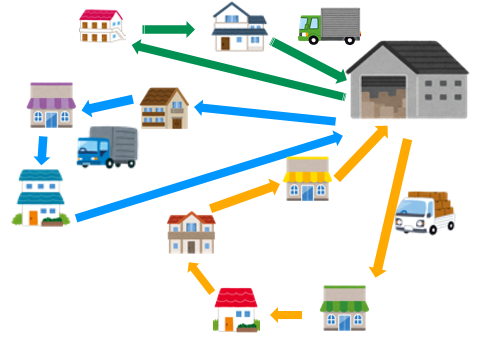

次のデモは、ランダムに生成した容量制約付き運搬経路問題をQUBOとして定式化し、Amplify AEで解を求めます。  
  
`Run`ボタンを押すと最適化が実行され、結果が下の地図に描写されます。車の台数、需要地の数、実行時間の変更は`Options`から行えます。  
デポや需要地の座標を変更したい場合は`Change Location`ボタンを押してください。  
うまく最適化できていない場合は、実行時間を延ばしてからお試しください。

In [ ]:
import folium
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic

from ipywidgets import (
    Button,
    IntSlider,
    interactive_output,
    VBox,
    HBox,
    Output,
    Label,
    Accordion,
    IntProgress,
    GridBox,
    GridspecLayout,
)
from IPython.display import display

from amplify import (
    Solver,
    BinarySymbolGenerator,
    BinaryPoly,
    sum_poly,
    einsum,
    InequalityFormulation,
)
from amplify.client import FixstarsClient
from amplify.constraint import less_equal, one_hot

zoom = 8.5
_colors = [
    "green",
    "orange",
    "blue",
    "red",
    "purple",
    "pink",
    "darkblue",
    "cadetblue",
    "darkred",
    "lightred",
    "darkgreen",
    "lightgreen",
    "lightblue",
    "darkpurple",
]
client = FixstarsClient()
client.parameters.timeout = 2000  # タイムアウト2秒
# client.token="xxxxxxxxxxxxxxx" # ローカル実行時にはtokenを指定。
solver = Solver(client)

In [ ]:
# 問題作成

In [ ]:
class Params:
    def __init__(
        self,
        lon_range,
        lat_range,
        nvehicle=None,
        dimension=None,
        demand=None,
        capacity=None,
        lb=10,
        ub=30,
        timeout=2000,
        seed=None,
    ):
        """
        車の台数、顧客数を求めたあと、各顧客の需要と各車の容量を決定し、
        顧客の座標をランダムに計算する。
        demandとcapacityはCVRPLIBから取ってくる。
        """
        self.lon_range = lon_range
        self.lat_range = lat_range
        self.timeout = timeout
        if seed is not None:
            np.random.seed(seed)
        if nvehicle is None:
            self.nvehicle = np.random.randint(2, 5)
        else:
            self.nvehicle = nvehicle
        if dimension is None:
            self.dimension = np.random.randint(lb, ub)
        else:
            self.dimension = dimension
        if demand is None:
            self.demand = np.random.randint(1, 100, size=self.dimension)
            self.demand[0] = 0  # depot
        else:
            self.demand = demand
        if capacity is None:
            tmp = self.dimension // self.nvehicle
            if isinstance(self.demand, dict):
                demand_max = max(self.demand)
                demand_mean = int(sum(self.demand) / len(self.demand))
            else:
                demand_max = np.max(self.demand)
                demand_mean = int(np.sum(self.demand) / len(self.demand))
            self.capacity = demand_max + demand_mean * tmp
        else:
            self.capacity = capacity

        self.coord = {
            i: (
                np.random.uniform(self.lon_range[0], self.lon_range[1]),
                np.random.uniform(self.lat_range[0], self.lat_range[1]),
            )
            for i in range(self.dimension)
        }

        self.distance_matrix = np.array(
            [
                [
                    geodesic(coord_i[::-1], coord_j[::-1]).m
                    for coord_j in self.coord.values()
                ]
                for coord_i in self.coord.values()
            ]
        )

    def __str__(self):
        return f"dimension={self.dimension}, nvehicle={self.nvehicle}, capacity={self.capacity}"

In [ ]:
# プロット

In [ ]:
def plot_solution(coord: dict, title: str, best_tour: dict = dict()):
    l = len(coord)
    center = [
        sum(lat for _, lat in coord.values()) / l,
        sum(lon for lon, _ in coord.values()) / l,
    ]
    m = folium.Map(center, tiles="OpenStreetMap", zoom_start=8.5)
    folium.Marker(
        location=coord[0][::-1],
        popup=f"depot",
        icon=folium.Icon(icon="car", prefix="fa"),
    ).add_to(m)

    _color = _colors[1]
    if best_tour:
        for k, tour in best_tour.items():
            _color = _colors[k % len(_colors)]
            x = [coord[i][0] for i in tour]
            y = [coord[i][1] for i in tour]

            for city in tour:
                if city == 0:
                    continue
                a, b = coord[city]

                folium.Marker(
                    location=[b, a],
                    popup=f"person{k}",
                    icon=folium.Icon(
                        icon="user", prefix="fa", color="white", icon_color=_color
                    ),
                ).add_to(m)
            folium.vector_layers.PolyLine(
                locations=[(a, b) for a, b in zip(y, x)], color=_color, weight=3
            ).add_to(m)
    else:
        for k, node in coord.items():
            if k == 0:
                continue
            folium.Marker(
                location=node[::-1],
                popup=f"customer{k}",
                icon=folium.Icon(
                    icon="user", prefix="fa", color="white", icon_color=_color
                ),
            ).add_to(m)

    title = f"<h4>{title}</h4>"
    m.get_root().html.add_child(folium.Element(title))
    display(m)

In [ ]:
# モデル作成

In [ ]:
def upperbound_of_tour(capacity: int, demand: np.ndarray) -> int:
    max_tourable_cities = 2
    for w in sorted(demand):
        capacity -= w
        if capacity >= 0:
            max_tourable_cities += 1
        else:
            return max_tourable_cities
    return max_tourable_cities

In [ ]:
def set_objective(x, distance_matrix):
    # 経路の総距離
    xr = x.roll(-1, axis=0)
    # 経路の総距離
    objective = einsum("pq,ipk,iqk", distance_matrix, x, xr)

    return objective

In [ ]:
def assign_to_init_constraints(x):
    x[0][1:][:] = BinaryPoly(0)
    x[-1][1:][:] = BinaryPoly(0)

    x[0][0][:] = BinaryPoly(1)
    x[-1][0][:] = BinaryPoly(1)

In [ ]:
def make_onetrip_constraints(x) -> list:
    max_tourable_cities = x.shape[0]
    dimension = x.shape[1]
    nvehicle = x.shape[2]

    constraints = [
        one_hot(sum_poly(dimension, lambda j: x[i][j][k]))
        for i in range(max_tourable_cities)
        for k in range(nvehicle)
    ]
    return constraints

In [ ]:
def make_onevisit_constraints(x) -> list:
    max_tourable_cities = x.shape[0]
    dimension = x.shape[1]
    nvehicle = x.shape[2]

    constraints = [
        one_hot(
            sum_poly(
                max_tourable_cities, lambda i: sum_poly(nvehicle, lambda k: x[i][j][k])
            )
        )
        for j in range(1, dimension)
    ]
    return constraints

In [ ]:
def make_capacity_constraints(x, demand: np.ndarray, capacity: int) -> list:
    max_tourable_cities = x.shape[0]
    dimension = x.shape[1]
    nvehicle = x.shape[2]

    constraints = [
        less_equal(
            demand * x[:, :, k],
            capacity,
            method=InequalityFormulation.RelaxationQuadra,
        )
        / capacity
        / capacity
        for k in range(nvehicle)
    ]

    return constraints

In [ ]:
# 後処理

In [ ]:
def onehot2_sequence(x_values) -> dict[int, list]:
    nvehicle = x_values.shape[2]
    sequence = dict()
    for k in range(nvehicle):
        sequence[k] = np.where(x_values[:, :, k])[1]
    return sequence

In [ ]:
def process_sequence(sequence: dict[int, list]) -> dict[int, list]:
    new_seq = dict()
    for k, v in sequence.items():
        series_len = np.count_nonzero(v != 0) + 2
        series = np.zeros(series_len, dtype=np.int32)
        series[1:-1] = v[v != 0]
        new_seq[k] = series
    return new_seq

In [ ]:
# メインの処理

In [ ]:
def construct_model(dimension, nvehicle, demand, capacity, distance_matrix):
    gen = BinarySymbolGenerator()
    max_tourable_cities = upperbound_of_tour(capacity, demand)
    x = gen.array(max_tourable_cities, dimension, nvehicle)

    assign_to_init_constraints(x)

    objective = set_objective(x, distance_matrix)

    constraints1 = make_onetrip_constraints(x)
    constraints2 = make_onevisit_constraints(x)
    constraints3 = make_capacity_constraints(x, demand, capacity)
    constraints = sum(constraints1) + sum(constraints2) + sum(constraints3)

    distance_max = np.max(distance_matrix)
    model = objective + constraints * distance_max

    return model, x

In [ ]:
def CVRP_initialize(
    dimension: int = 10,
    nvehicle: int = 1,
    timeout: int = 1000,
    seed=None,
):
    global best_tour
    global params

    # 埼玉・千葉・東京近辺
    lat_range = [35.7014, 35.968]
    lon_range = [139.34, 140.04]
    best_tour = None
    params = Params(
        lon_range,
        lat_range,
        nvehicle=nvehicle,
        dimension=dimension,
        timeout=timeout,
        seed=seed,
    )
    title = str(params)
    title = f"dimension={params.dimension}, nvehicle={params.nvehicle}, capacity={params.capacity}"
    plot_solution(params.coord, title)


def CVRP_solve(progress):
    global params
    global best_tour
    model, x = construct_model(
        params.dimension,
        params.nvehicle,
        params.demand,
        params.capacity,
        params.distance_matrix,
    )
    progress.value += 1

    client = FixstarsClient()
    client.parameters.timeout = params.timeout
    solver = Solver(client)

    result = solver.solve(model)
    progress.value += 1

    if len(result.solutions) == 0:
        raise RuntimeError("Some of the constraints are not satisfied.")
    x_values = result.solutions[0].values
    new_seq = onehot2_sequence(x.decode(x_values))
    best_tour = process_sequence(new_seq)
    progress.value += 1

    title = f"{str(params)}, cost={result.solutions[0].energy:.2f}"
    progress.value += 1

    plot_solution(params.coord, title, best_tour)
    progress.value += 1


def CVRP_vis_capacity():
    global params
    global best_tour

    plt.figure(figsize=(8, 6))
    plt.ylabel("Load Capacity")
    plt.title("Load Capacity", y=1.08, size="x-large")
    if best_tour:
        for k, v in best_tour.items():
            bottom = 0
            _v = np.unique(v)
            for i in _v:
                if i == 0:
                    continue
                plt.bar(
                    [k],
                    [params.demand[i]],
                    label=f"customer{i}(demand={params.demand[i]})",
                    bottom=bottom,
                )
                bottom += params.demand[i]
        plt.legend(
            bbox_to_anchor=(0, -0.055), loc="upper left", borderaxespad=0, ncol=2
        )
    plt.grid(True, axis="y", color="gainsboro", alpha=0.8, zorder=7)
    plt.hlines(params.capacity, -1, params.nvehicle, color="red")
    plt.xticks(
        list(range(params.nvehicle)), [f"vehicle {k}" for k in range(params.nvehicle)]
    )
    plt.yticks([params.capacity], [f"Capacity\n{params.capacity}"], color="red")
    plt.show()
    print(params)

In [ ]:
customer_slider = IntSlider(
    value=10,
    min=0,
    max=30,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
)
vehicle_slider = IntSlider(
    value=2,
    min=0,
    max=5,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
)
time_slider = IntSlider(
    value=1500,
    min=100,
    max=5000,
    step=50,
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
)


options1 = [Label(value="車両台数 ( nvehicle ) :"), vehicle_slider]
options1 += [Label(value="顧客数 ( dimension ) :"), customer_slider]

options2 = [Label(value="制限時間 [ ms ] :"), time_slider]

options = [GridBox(options1), GridBox(options2)]
options = Accordion(children=[HBox(options)])
options.set_title(0, "Options")
options.selected_index = None

progress = IntProgress(
    value=0,
    min=0,
    max=7,
    step=1,
    description="Solving...",
    bar_style="info",
    orientation="horizontal",
)
CVRP_run_btn = Button(description="Run", button_style="", tooltip="Run", icon="check")

CVRP_relocate_btn = Button(
    description="Change Location", button_style="", tooltip="Change Location", icon=""
)

CVRP_out = Output()
CVRP_LoadCap_out = Output()


def show_CVRP_problem(dimension, nvehicle, timeout, seed=None):
    progress.value = 0
    CVRP_initialize(dimension, nvehicle, timeout, seed=seed)
    with CVRP_LoadCap_out:
        CVRP_LoadCap_out.clear_output()
        CVRP_vis_capacity()


def show_CVRP_problem_relocate(btn):
    progress.value = 0
    with CVRP_LoadCap_out:
        CVRP_LoadCap_out.clear_output()
    with CVRP_out:
        CVRP_out.clear_output()
        CVRP_initialize(
            customer_slider.value,
            vehicle_slider.value,
            time_slider.value,
            seed=None,
        )
    with CVRP_LoadCap_out:
        CVRP_vis_capacity()


def show_CVRP_result(btn):
    progress.value = 0
    with CVRP_LoadCap_out:
        CVRP_LoadCap_out.clear_output()
    with CVRP_out:
        progress.value += 1
        CVRP_out.clear_output()
        progress.value += 1
        CVRP_solve(progress)
    with CVRP_LoadCap_out:
        CVRP_vis_capacity()


CVRP_out = interactive_output(
    show_CVRP_problem,
    {
        "dimension": customer_slider,
        "nvehicle": vehicle_slider,
        "timeout": time_slider,
    },
)
CVRP_LoadCap_out = interactive_output(
    CVRP_vis_capacity,
    {},
)

CVRP_relocate_btn.on_click(show_CVRP_problem_relocate)
CVRP_run_btn.on_click(show_CVRP_result)

grid = GridspecLayout(10, 10)
right = 3

grid[1:, :right] = CVRP_out
grid[0, 0] = CVRP_run_btn
grid[0, 1] = CVRP_relocate_btn
grid[0, 2] = progress
grid[1:, right:] = CVRP_LoadCap_out

display(VBox([options, grid]))